In [1]:
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry.point import Point
import seaborn as sns
from functools import reduce
from pyproj import CRS
from pyproj import Transformer
import datetime
import multiprocessing
import time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from tqdm import tqdm

In [2]:
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
intrastate_travellers_data = pd.read_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_5_valid_IDs_intrastate_travellers.csv')
intrastate_travellers_data['datetime'] = pd.to_datetime(intrastate_travellers_data['datetime'])

In [ ]:
df_chardham= pd.read_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Char dham\df_chardham_visitors.csv')

In [4]:
df = pd.read_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Activity determination\Trajectory 2\UK_records_37157_IDs.csv')

In [ ]:
# Step 1: Filter for nighttime records (example: 10 PM to 6 AM)

def filter_nighttime(df):
    def is_nighttime(dt):
        hour = dt.hour
        return hour >= 22 or hour <= 6
    
    df['nighttime'] = df['datetime'].apply(is_nighttime)
    nighttime_df = df[df['nighttime']]
    return nighttime_df

# Step 2: Group by ID and apply clustering to determine home locations
def find_home_locations(nighttime_df, eps=0.005, min_samples=1, home_threshold=0.9):
    home_locations = {}
    
    for maid, group in nighttime_df.groupby('maid'):
        coords = group[['latitude', 'longitude']].values
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=great_circle).fit(coords)
        
        group['cluster'] = db.labels_
        
        # Step 3: Determine the home cluster
        cluster_counts = group['cluster'].value_counts(normalize=True)
        home_cluster = cluster_counts[cluster_counts > home_threshold].index[0]
        
        # Step 4: Extract the home location
        home_coords = group[group['cluster'] == home_cluster][['latitude', 'longitude']].mean()
        
        home_locations[maid] = home_coords
    
    # Convert the dictionary to a DataFrame for easier analysis
    home_df = pd.DataFrame.from_dict(home_locations, orient='index', columns=['home_latitude', 'home_longitude'])
    return home_df



## Projection

In [3]:
# poly_file = gpd.read_file('/content/drive/MyDrive/TAMACO/India_shapefile/India Shape/geojson_file.geojson')
poly_file = gpd.read_file(r"C:\Users\Admin\Desktop\Desktop\GeoJSON files\UK_Districts\UK_districts_not_simplified.geojson")
shape_uttarakhand = poly_file["geometry"]
# shape_uttarakhand
# poly_file

Skipping field parents: unsupported OGR type: 1


In [7]:
# df_chardham['datetime'] = pd.to_datetime(df_chardham['datetime'])
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
# intrastate_travellers_data["date"] = [x.date() for x in intrastate_travellers_data["datetime"] ]
# intrastate_travellers_data["time" ] = [x.time() for x in intrastate_travellers_data["datetime"]]
# df_chardham["date"] = [x.date() for x in df_chardham["datetime"] ]
# df_chardham["time" ] = [x.time() for x in df_chardham["datetime"]]
df["date"] = [x.date() for x in df["datetime"] ]
df["time" ] = [x.time() for x in df["datetime"]]

In [ ]:
# df_chardham.rename(columns = {'latitude_left':'latitude', 'longitude_left':'longitude'}, inplace=True)

<Axes: xlabel='longitude', ylabel='latitude'>

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


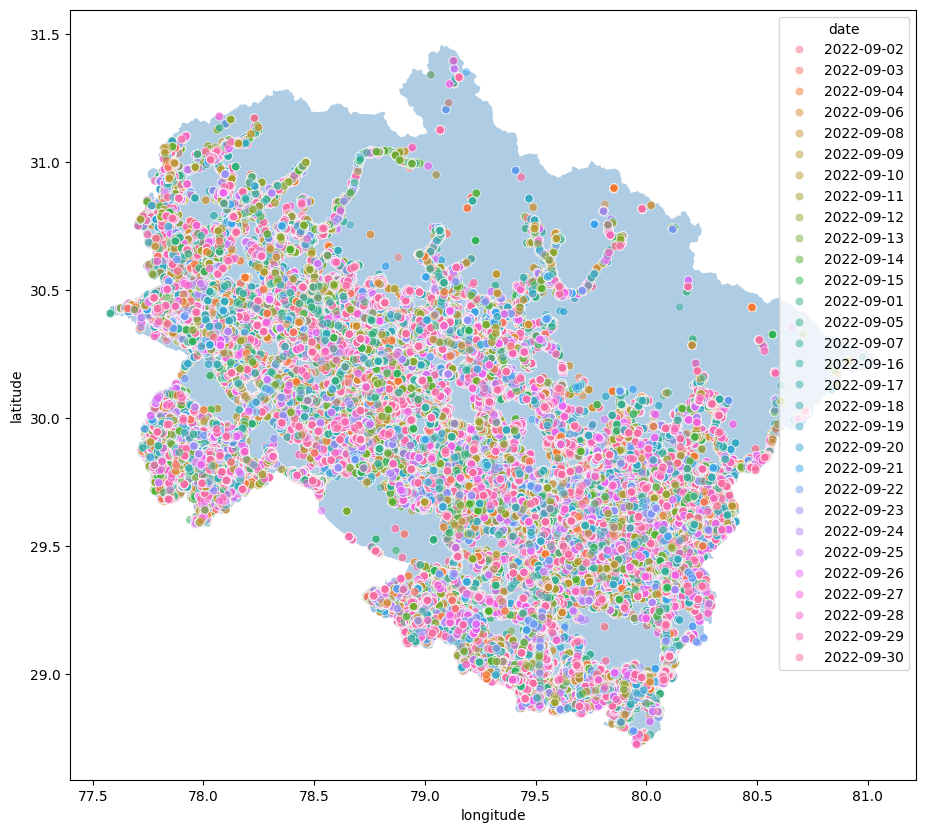

In [9]:
import seaborn
# uttarakhand_data
fig ,ax = plt.subplots( 1,1 ,figsize = (16,10))
shape_uttarakhand.plot(alpha = 0.2 , ax = ax )
sns.scatterplot( data = df , y = "latitude" , x = "longitude" , hue = "date" , ax= ax , alpha = 0.5)

In [10]:
# Projection

crs_4326 = CRS("WGS84")  # source CRS that is lat and lon
crs_proj = CRS("EPSG:3857")    #for Uttarakhand, x and y
transformer = Transformer.from_crs(crs_4326, crs_proj)

def convert_to_CRS( latitude , longitude ) :
    y , x =   transformer.transform( latitude , longitude )
    return ( y,  x )
# intrastate_travellers_data["y"] ,intrastate_travellers_data["x"] = convert_to_CRS(intrastate_travellers_data.latitude , intrastate_travellers_data.longitude  )
# df_chardham
# df_chardham["y"] ,df_chardham["x"] = convert_to_CRS(df_chardham.latitude , df_chardham.longitude  )
df["y"] ,df["x"] = convert_to_CRS(df.latitude , df.longitude  )


Text(0, 0.5, 'Data Available')

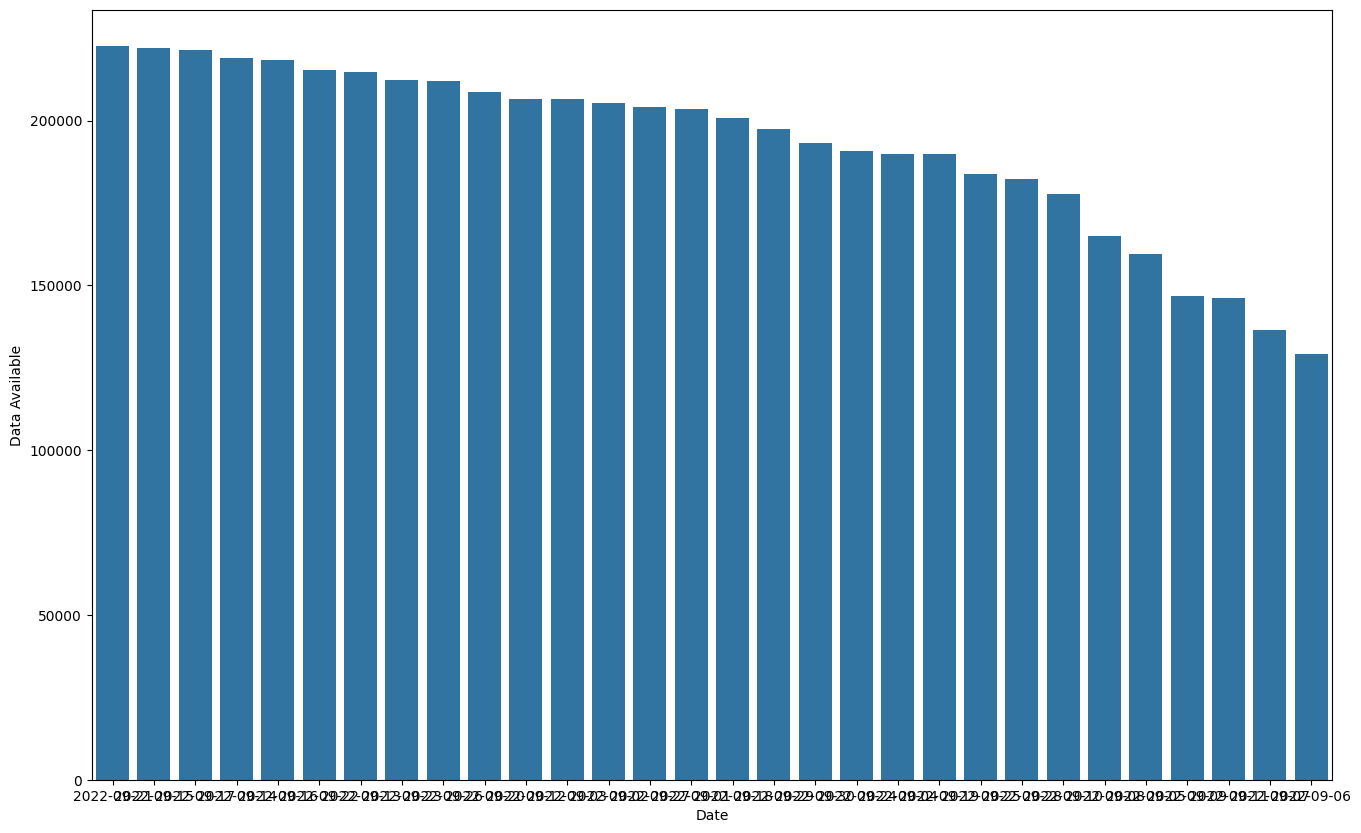

In [11]:
fig ,ax = plt.subplots( 1,1 ,figsize = (16,10))
# date_val_cnt = (df_chardham["date"]).value_counts()

date_val_cnt = (df["date"]).value_counts()
# date_val_cnt = (intrastate_travellers_data["date"]).value_counts()
sns.barplot(x  = date_val_cnt.index ,y = date_val_cnt.values ) 
plt.xlabel("Date")
plt.ylabel("Data Available")

In [13]:
# grid_size = 250 # in metres
grid_size = 250

x_min     = df.x.min()
y_min     = df.y.min()
# x_min     = df_chardham.x.min()
# y_min     = df_chardham.y.min()

In [14]:
def time_bin( time_  , bin_size = 5 ) :
    time1_delta = datetime.timedelta(hours=time_.hour, minutes=time_.minute, seconds=time_.second)
    time2_delta = datetime.timedelta(hours=0, minutes=0, seconds=0)

    factor = 60 * bin_size 
    bin_number =  ((time1_delta - time2_delta) / factor ).seconds

    return "t_"+ str(bin_number)

In [15]:
def get_group( x , y , x_min = x_min ,y_min = y_min , gap = grid_size ) :
    x_ =  int( (x - x_min) / gap )
    y_ =  int( (y - y_min) / gap )
    group = "x_" + str( x_ )+ "y_" + str( y_  )
    return group

In [16]:
def extract_indices_from_group(group):
    # Extract x_ and y_ from the group string
    x_part, y_part = group.split('y_')
    x_ = int(x_part.replace('x_', ''))
    y_ = int(y_part)
    return x_, y_

# Convert position groups to indices
def position_group_to_indices(group):
    x_, y_ = extract_indices_from_group(group)
    return x_, y_




In [17]:
# df_chardham
# intrastate_travellers_data["position_group"] = intrastate_travellers_data.apply( lambda row : get_group( row.x , row.y ) ,axis = 1)
# intrastate_travellers_data["time_group"] = intrastate_travellers_data.apply( lambda row : time_bin( row.datetime ) ,axis = 1)
# df_chardham["position_group"] = df_chardham.apply( lambda row : get_group( row.x , row.y ) ,axis = 1)
# df_chardham["time_group"] = df_chardham.apply( lambda row : time_bin( row.datetime ) ,axis = 1)
df["position_group"] = df.apply( lambda row : get_group( row.x , row.y ) ,axis = 1)
df["time_group"] = df.apply( lambda row : time_bin( row.datetime ) ,axis = 1)

In [19]:
df.drop(columns=['dist_previous_next',
       'time_gap_previous_next', 'next_valid_index', 'keep',
       'prev_valid_index'], inplace=True)

In [36]:
unique_position_groups = df_chardham[['position_group']].drop_duplicates().reset_index(drop=True)
unique_position_groups[['x_', 'y_']] = unique_position_groups['position_group'].apply(lambda grp: pd.Series(position_group_to_indices(grp)))

# Compute centroids
unique_position_groups['centroid_x'] = x_min + (unique_position_groups['x_'] + 0.5) * grid_size
unique_position_groups['centroid_y'] = y_min + (unique_position_groups['y_'] + 0.5) * grid_size

# Merge with original DataFrame
df_chardham = pd.merge(df_chardham, unique_position_groups[['position_group', 'centroid_x', 'centroid_y']], on='position_group', how='left')


In [37]:
df_chardham.columns

Index(['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'state', 'district', 'highway', 'name_en_left',
       'place_name', 'Activity_trace', 'date', 'Activity_type', 'Travel_mode',
       'origin_state', 'origin_district', 'geometry', 'boundary_name',
       'index_right', 'name', 'latitude_right', 'longitude_right',
       'dist_from_temp(m)', 'Chaar_dham_activity', 'time', 'y', 'x',
       'position_group', 'time_group', 'centroid_x', 'centroid_y'],
      dtype='object')

In [38]:
df_chardham.to_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Char dham\df_chardham_visitors_with_position_groups.csv', index=False)


In [20]:
df.to_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Activity determination\Trajectory 2\UK_records_37157_IDs_with_position_groups.csv', index=False)

In [ ]:
intrastate_travellers_data.head(10)

In [ ]:
sample_data = intrastate_travellers_data[intrastate_travellers_data['maid'].isin(set(['0d17bac0-bfaa-4cac-92de-ac0181cc5760']))]

In [ ]:
import pandas as pd
from datetime import timedelta
from tqdm import tqdm

def add_duplicate_records(df, speed, X):
    # Convert X to timedelta and pre-calculate total hours
    X_td = pd.to_timedelta(X)
    hours = X_td.total_seconds() // 3600  # 3600 seconds in an hour

    # Sort dataframe by maid and datetime
    df = df.sort_values(by=['maid', 'datetime']).reset_index(drop=True)

    # Group the dataframe by 'maid' to avoid repetitive filtering
    grouped = df.groupby('maid')

    # Pre-allocate a list to collect all records
    all_records = []

    # Iterate over each group with a progress bar
    for maid, group in tqdm(grouped, desc='Processing MAIDs'):
        group_records = []

        # Convert group DataFrame to a list of records for faster iteration
        records = group.to_dict('records')

        # Outer Loop: Iterate over records in the group
        for i in range(len(records) - 1):
            record_k = records[i]
            record_k1 = records[i + 1]

            # Determine the current date and X_new
            curr_date = record_k['datetime'].date()
            if record_k['datetime'].hour > hours:
                curr_date += timedelta(days=1)
            X_new = pd.Timestamp(curr_date) + X_td

            # Check if the new timestamp fits between the current and next records
            if record_k['datetime'] < X_new < record_k1['datetime']:
                # Calculate feasible time
                feasible_time = record_k1['datetime'] - timedelta(seconds=(record_k1['displacement'] / speed) * 3600)

                # If feasible time is greater than X_new, create a duplicate record
                if feasible_time > X_new:
                    duplicate_record = record_k.copy()
                    duplicate_record['datetime'] = X_new
                    duplicate_record['dummy'] = True  # Mark duplicate record

                    # Add the current record and the duplicate record
                    group_records.append(record_k)
                    group_records.append(duplicate_record)
                else:
                    group_records.append(record_k)
            else:
                group_records.append(record_k)

        # Add the last record of the group
        group_records.append(records[-1])

        # Collect results for the current maid
        all_records.extend(group_records)

    # Convert the list of records back to a DataFrame
    return pd.DataFrame(all_records)

# Example usage:
speed = 75  # Speed in km/hr
X = '06:00:00'

# Load your DataFrame (replace with your actual DataFrame loading code)
# df = pd.read_csv('your_dataframe.csv')

# Apply the function
sample_data_copy = add_duplicate_records(intrastate_travellers_data[intrastate_travellers_data['maid']=='00773b5a-6469-4e9c-99a0-bfb285e3c707'].copy(deep=True), speed, X)

X = '22:00:00'  # Time to check
sample_data_copy = add_duplicate_records(sample_data_copy, speed, X)

X = '08:00:00'  # Time to check
sample_data_copy = add_duplicate_records(sample_data_copy, speed, X)

X = '18:00:00'  # Time to check
sample_data_copy = add_duplicate_records(sample_data_copy, speed, X)

# Display the result
sample_data_copy.head(20)


In [ ]:
sample_data = sample_data.reset_index(drop=True)

In [ ]:
speed = 75  # Speed in km/hr
X='06:00:00'
# df = pd.read_csv('your_dataframe.csv')  # Load your DataFrame
intrastate_travellers_data_dummy = add_duplicate_records(intrastate_travellers_data.copy(deep=True), speed, X)
X = '22:00:00'  # Time to check
intrastate_travellers_data_dummy = add_duplicate_records(intrastate_travellers_data_dummy, speed, X)
X = '08:00:00'  # Time to check
intrastate_travellers_data_dummy = add_duplicate_records(intrastate_travellers_data_dummy, speed, X)
X = '18:00:00'  # Time to check
intrastate_travellers_data_dummy = add_duplicate_records(intrastate_travellers_data_dummy, speed, X)
intrastate_travellers_data_dummy.head(20)
# intrastate_travellers_data_dummy = 

In [ ]:
intrastate_travellers_data_dummy.to_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_5_valid_IDs_intrastate_travellers_dummy_records_added.csv', index=False)

In [ ]:
import pandas as pd

In [ ]:
intrastate_travellers_data_dummy= pd.read_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_5_valid_IDs_intrastate_travellers_dummy_records_added.csv')

In [ ]:

def calculate_night_time_activity_time(df, group_date, speed=75):
    # pr("Starting group_and_calculate_nighttime")
    df['nighttime'] = df['datetime'].dt.hour.between(22, 23) | df['datetime'].dt.hour.between(0, 5)
    nighttime_indices = df.index[df['nighttime']].tolist()
    # pr(f"nighttime_indices: {nighttime_indices}")
    
    

    flag = True
    if nighttime_indices:
        group_night_times = defaultdict(list)
        current_group = (df.loc[nighttime_indices[0], 'position_group'])
        start_time = df.loc[nighttime_indices[0], 'datetime']
        threshold_start_time = pd.Timestamp.combine(group_date, pd.Timestamp("22:00:00").time())
        end_date = group_date + pd.Timedelta(days=1)
        threshold_end_time = pd.Timestamp.combine(end_date, pd.Timestamp("06:00:00").time())
        
        
        # pr(f"threshold_start_time: {threshold_start_time}")
        # pr(f"threshold_end_time: {threshold_end_time}")
        
        if nighttime_indices[0] != 0:
            flag = False
            prev_group = (df.loc[nighttime_indices[0] -1 , 'position_group'])
            first_nighttime_index = nighttime_indices[0]
            prev_index = nighttime_indices[0] - 1
            prev_record = df.loc[prev_index]
            group_distance = ((prev_record['centroid_x'] - df.loc[first_nighttime_index]['centroid_x'])**2 + 
                                (prev_record['centroid_y'] - df.loc[first_nighttime_index]['centroid_y'])**2)**0.5
            feasible_time = df.loc[first_nighttime_index]['datetime'] - pd.Timedelta(hours=group_distance / (speed * 1000))
            # pr(f"feasible_time (initial): {feasible_time}")
            
            if feasible_time > threshold_start_time:
                # start_time = threshold_start_time
                group_night_times[prev_group].append([threshold_start_time, feasible_time])
                # pr(f"record added for {prev_group}: {[threshold_start_time, feasible_time]}")
        if flag:
            start_index=1
        else:
            start_index=2
        for i in range(start_index, len(nighttime_indices)):
            prev_index = nighttime_indices[i-1]
            curr_index = nighttime_indices[i]
            prev = df.loc[prev_index]
            curr = df.loc[curr_index]
            # pr(f"Processing transition from index {prev_index} to {curr_index}")
            
            if (curr['position_group']) != (prev['position_group']):
                group_distance = ((curr['centroid_x'] - prev['centroid_x'])**2 + (curr['centroid_y'] - prev['centroid_y'])**2)**0.5
                feasible_time = curr['datetime'] - pd.Timedelta(hours=group_distance / (speed * 1000))
                # pr(f"feasible_time: {feasible_time}")
                
                if feasible_time < start_time:
                    group_night_times[(prev['position_group'])].append([start_time, start_time])
                    prev_group = (prev['position_group'])
                    # pr(f"record added for {prev_group}: {[start_time, start_time]}")
                else:
                    end_time = min(feasible_time, threshold_end_time)  #should always be feasible_time
                    
                    group_night_times[(prev['position_group'])].append([start_time, end_time])
                    prev_group = (prev['position_group'])
                    # pr(f"record added for prev group {prev_group}: {[start_time, end_time]}")
                
                # Print the transition times
                # pr(f"Transition for group {(prev[position_group])}: [start_time, end_time] -> [{start_time}, {end_time}]")
                
                start_time = curr['datetime']
                current_group = (curr['position_group'])
        
        last_nighttime_index = nighttime_indices[-1]
        next_index = last_nighttime_index + 1
        
        if next_index < len(df):
            next_record = df.loc[next_index]
            group_distance = ((next_record['centroid_x'] - df.loc[last_nighttime_index]['centroid_x'])**2 + 
                                (next_record['centroid_y'] - df.loc[last_nighttime_index]['centroid_y'])**2)**0.5
            feasible_time = next_record['datetime'] - pd.Timedelta(hours=group_distance / (speed * 1000))
            
            if feasible_time < start_time:
                end_time = min(start_time, threshold_end_time)
            else:
                end_time = min(feasible_time, threshold_end_time)
            # pr(f"end_time for last index: {end_time}")
            
            # Print the last transition times
            # pr(f"Last transition for group {current_group}: [start_time, end_time] -> [{start_time}, {end_time}]")
            
            group_night_times[current_group].append([start_time, end_time])
            # pr(f"record added for current group {current_group}: {[start_time, end_time]}")
            
    # pr(f'df in function: {df.columns}')
        else:
            group_night_times[current_group].append([start_time, threshold_end_time])
    

        return group_night_times, df[['maid', 'position_group', 'centroid_x', 'centroid_y', 'state', 'district', 'group', 'nighttime']]
    else:
        df['nighttime'] = None
        return {}, df[['maid','position_group', 'centroid_x', 'centroid_y', 'group', 'nighttime']]



def calculate_daytime_activity_time(df, group_date, speed=75):
    # curr_date = group_date+ pd.Timedelta(days=1) #since group by is done on custom time of 22:00:00
    # df = df[df['datetime'].dt.date ==curr_date]
    # pr("Starting group_and_calculate_daytime")
    df['office_hours'] = df['datetime'].dt.hour.between(8,17)
    daytime_indices = df.index[df['office_hours']].tolist()
    # pr(f"daytime_indices: {daytime_indices}")
    # if not daytime_indices:
    
    flag = True
    if daytime_indices:
        group_day_times = defaultdict(list)
        current_group = (df.loc[daytime_indices[0], 'position_group'])
        start_time = df.loc[daytime_indices[0], 'datetime']
        threshold_start_time = pd.Timestamp.combine(group_date, pd.Timestamp("08:00:00").time())
        
        threshold_end_time = pd.Timestamp.combine(group_date, pd.Timestamp("18:00:00").time())
        
        # pr(f"threshold_start_time: {threshold_start_time}")
        # pr(f"threshold_end_time: {threshold_end_time}")
        if daytime_indices[0] != 0:
            flag = False
            prev_group = (df.loc[daytime_indices[0] -1 , 'position_group'])
            first_daytime_index = daytime_indices[0]
            prev_index = daytime_indices[0] - 1
            prev_record = df.loc[prev_index]
            group_distance = ((prev_record['centroid_x'] - df.loc[first_daytime_index]['centroid_x'])**2 + 
                                (prev_record['centroid_y'] - df.loc[first_daytime_index]['centroid_y'])**2)**0.5
            feasible_time = df.loc[first_daytime_index]['datetime'] - pd.Timedelta(hours=group_distance / (speed * 1000))
            # pr(f"feasible_time (initial): {feasible_time}")
            
            if feasible_time > threshold_start_time:
                # start_time = threshold_start_time
                group_day_times[prev_group].append([threshold_start_time, feasible_time])
                # pr(f"record added for {prev_group}: {[threshold_start_time, feasible_time]}")
        if flag:
            start_index=1
        else:
            start_index=2
        for i in range(start_index, len(daytime_indices)):
            prev_index = daytime_indices[i-1]
            curr_index = daytime_indices[i]
            prev = df.loc[prev_index]
            curr = df.loc[curr_index]
            # pr(f"Processing transition from index {prev_index} to {curr_index}")
            
            if (curr['position_group']) != (prev['position_group']):
                group_distance = ((curr['centroid_x'] - prev['centroid_x'])**2 + (curr['centroid_y'] - prev['centroid_y'])**2)**0.5
                feasible_time = curr['datetime'] - pd.Timedelta(hours=group_distance / (speed * 1000))
                # pr(f"feasible_time: {feasible_time}")
                
                if feasible_time < start_time:
                    group_day_times[(prev['position_group'])].append([start_time, start_time])
                    prev_group = (prev['position_group'])
                    # pr(f"record added for {prev_group}: {[start_time, start_time]}")
                else:
                    end_time = min(feasible_time, threshold_end_time)  #should always be feasible_time
                    
                    group_day_times[(prev['position_group'])].append([start_time, end_time])
                    prev_group = (prev['position_group'])
                    # pr(f"record added for prev group {prev_group}: {[start_time, end_time]}")
                
                # Print the transition times
                # pr(f"Transition for group {(prev[position_group])}: [start_time, end_time] -> [{start_time}, {end_time}]")
                
                start_time = curr['datetime']
                # pr(f' index: {curr_index} start time: {start_time}')
                current_group = (curr['position_group'])
        
        last_daytime_index = daytime_indices[-1]
        next_index = last_daytime_index + 1
        
        if next_index < len(df):
            next_record = df.loc[next_index]
            group_distance = ((next_record['centroid_x'] - df.loc[last_daytime_index]['centroid_x'])**2 + 
                                (next_record['centroid_y'] - df.loc[last_daytime_index]['centroid_y'])**2)**0.5
            feasible_time = next_record['datetime'] - pd.Timedelta(hours=group_distance / (speed * 1000))
            if feasible_time < start_time:
                end_time = min(start_time, threshold_end_time)
            else:
                end_time = min(feasible_time, threshold_end_time)
            # pr(f"end_time for last index: {end_time}")
            
            # Print the last transition times
            # pr(f"Last transition for group {current_group}: [start_time, end_time] -> [{start_time}, {end_time}]")
            
            group_day_times[current_group].append([start_time, end_time])
            # pr(f"record added for current group {current_group}: {[start_time, end_time]}")
        else:
            group_day_times[current_group].append([start_time, threshold_end_time])
        # pr(df.columns)
        
    #     ['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
    #    'Velocity', 'state', 'district', 'Nearest airport',
    #    'Coordinates of airport', 'Distance to airport (km)', 'uk_dist', 'y',
    #    'x', 'dummy', position_group, 'centroid_x', 'centroid_y', 'group', 'office_hours']
        return group_day_times, df[['maid','position_group', 'centroid_x', 'centroid_y',  'group', 'office_hours']]
    else:
        df['office_hourse']=None
        return {}, df[['maid','position_group', 'centroid_x', 'centroid_y',  'group', 'office_hours']]
    
 

In [ ]:
from sklearn.cluster import DBSCAN
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

import pandas as pd
from collections import defaultdict

def group_by_custom_intervals_with_extra(df_dict, start_time_offset_hours, interval_hours=24, include_previous=True):
    """
    Groups the dictionary by custom intervals with an option to include the previous record.
    Ensures that all dates in the specified range have a corresponding group, even if the DataFrame is empty for that date.

    Parameters:
    - df_dict (dict): The dictionary to be grouped.
    - interval_hours (int): The length of the interval in hours. Default is 24 hours.
    - start_time_offset_hours (int): The number of hours to offset the start time. Default is 2 hours.
    - include_previous (bool): Whether to include the previous record in each group. Default is True.

    Returns:
    - list of tuples: Each tuple contains the group name (date) and the corresponding DataFrame.
    """
    # Convert dict to DataFrame for easier manipulation
    df = pd.DataFrame(df_dict)

    start_date = pd.Timestamp('2022-09-01')
    end_date = pd.Timestamp('2022-09-30')
    start_time = start_date - pd.Timedelta(hours=start_time_offset_hours)

    # Calculate groups based on intervals
    df['group'] = ((df['datetime'] - start_time).dt.total_seconds() // (interval_hours * 3600)).astype(int)
    df['group_label'] = (start_time + pd.to_timedelta(df['group'] * interval_hours, unit='h')).dt.date

    # Group the DataFrame by the calculated group labels
    grouped = df.groupby('group_label')

    modified_groups = []
    for current_date in pd.date_range(start=start_date, end=end_date):
        current_date = current_date.date()

        if current_date in grouped.groups:
            group_records = grouped.get_group(current_date)
        else:
            group_records = pd.DataFrame(columns=df.columns)

        # Optionally include the previous record
        if include_previous and not group_records.empty:
            previous_record = group_records.iloc[-1:].copy()
            group_records = pd.concat([previous_record, group_records]).drop_duplicates()

        modified_groups.append((current_date, group_records))

    return modified_groups



def process_custom_groups_per_id(df, eps=250, min_samples=1, speed=75):
    df.reset_index(drop=True, inplace=True)
    all_final_dfs = []

    maids = df['maid'].unique()

    for maid in tqdm(maids, desc='Processing maid: '):
        maid_df = df[df['maid'] == maid]
        maid_dict = {col: maid_df[col].tolist() for col in maid_df.columns}
        
        # db = DBSCAN(eps=eps, min_samples=min_samples).fit(maid_df[['x', 'y']])
        # maid_dict['position_group'] = maid_df['position_group'].unique().tolist()

        # Calculate mean locations and store in dictionary
        # position_group_coords = defaultdict(lambda: {'x_sum': 0, 'y_sum': 0, 'count': 0})
        # for x, y, position_group in zip(maid_dict['x'], maid_dict['y'], maid_dict['position_group']):
        #     position_group_coords[position_group]['x_sum'] += x
        #     position_group_coords[position_group]['y_sum'] += y
        #     position_group_coords[position_group]['count'] += 1

        # maid_dict['centroid_x'] = [position_group_coords[c]['x_sum'] / position_group_coords[c]['count'] for c in maid_dict['position_group']]
        # maid_dict['centroid_y'] = [position_group_coords[c]['y_sum'] / position_group_coords[c]['count'] for c in maid_dict['position_group']]

        grouped_nighttime = group_by_custom_intervals_with_extra(maid_dict, start_time_offset_hours=2, interval_hours=24, include_previous=True)
        grouped_daytime = group_by_custom_intervals_with_extra(maid_dict, start_time_offset_hours=-6, interval_hours=24, include_previous=True)

        rows_day_time = []
        rows_night_time = []

        for (group_name_day, group_dict_day), (group_name_night, group_dict_night) in zip(grouped_daytime, grouped_nighttime):
            if group_name_day != group_name_night:
                print(f"Warning: Mismatch in group names: {group_name_day} vs {group_name_night}")
                continue
            # Convert group_dict_night to a DataFrame if it's not already one
            
            
            # Check if 'datetime' exists in the dictionary
            if 'datetime' not in group_dict_night:
                print("Error: 'datetime' key not found in group_dict_night.")
            else:
                # Convert group_dict_night to a DataFrame if it's not already one
                if not isinstance(group_dict_night, pd.DataFrame):
                    group_dict_night = pd.DataFrame(group_dict_night)
                    group_dict_night['datetime'] = pd.to_datetime(group_dict_night['datetime'])

            # Similarly for group_dict_day
            if 'datetime' not in group_dict_day:
                print("Error: 'datetime' key not found in group_dict_day.")
            else:
                if not isinstance(group_dict_day, pd.DataFrame):
                    group_dict_day = pd.DataFrame(group_dict_day)
                    group_dict_day['datetime'] = pd.to_datetime(group_dict_day['datetime'])

            # Now pass the DataFrames to the functions
            # group_night_times, night_df = calculate_night_time_activity_time(group_dict_night, group_name_night, eps=eps, min_samples=min_samples, speed=speed)
            # group_day_times, day_df = calculate_daytime_activity_time(group_dict_day, group_name_day, eps=eps, min_samples=min_samples, speed=speed)

            
            
            # if not isinstance(group_dict_night, pd.DataFrame):
            #     group_dict_night = pd.DataFrame(group_dict_night)
            group_dict_night['datetime'] = pd.to_datetime(group_dict_night['datetime'])

            # # Convert group_dict_day to a DataFrame if it's not already one
            # if not isinstance(group_dict_day, pd.DataFrame):
            #     group_dict_day = pd.DataFrame(group_dict_day)
                
            #     # print(f'group_dict_day columns: {group_dict_day.columns}')
            #     print(f'group_dict_day: {group_dict_day.head(1)}')
            group_dict_day['datetime'] = pd.to_datetime(group_dict_day['datetime'])
            group_dict_night = group_dict_night.reset_index(drop=True)    
            group_dict_day = group_dict_day.reset_index(drop=True)
            
            group_night_times, _ = calculate_night_time_activity_time(group_dict_night, group_name_night,  speed=speed)
            group_day_times, _ = calculate_daytime_activity_time(group_dict_day, group_name_day, speed=speed)

            for position_group, times in group_day_times.items():
                staying_time = sum((end - start).total_seconds() for start, end in times) / 3600
                centroid_x = group_dict_day['centroid_x'][0]
                centroid_y = group_dict_day['centroid_y'][0]
                state = group_dict_day['state'][0]
                district = group_dict_day['district'][0]

                rows_day_time.append({
                    'maid': maid,
                    'datetime_group': group_name_day,
                    'position_group': position_group,
                    'centroid_x': centroid_x,
                    'centroid_y': centroid_y,
                    'state': state,
                    'district': district,
                    'staying_time_day(hrs)': staying_time,
                })

            for position_group, times in group_night_times.items():
                staying_time = sum((end - start).total_seconds() for start, end in times) / 3600
                centroid_x = group_dict_night['centroid_x'][0]
                centroid_y = group_dict_night['centroid_y'][0]

                rows_night_time.append({
                    'maid': maid,
                    'datetime_group': group_name_night,
                    'position_group': position_group,
                    'centroid_x': centroid_x,
                    'centroid_y': centroid_y,
                    'state': state,
                    'district': district,
                    'staying_time_night(hrs)': staying_time,
                })

        daytime_df = pd.DataFrame(rows_day_time)
        nighttime_df = pd.DataFrame(rows_night_time)
        
        final_df = pd.merge(daytime_df, nighttime_df, how='outer', on=['maid', 'datetime_group', 'centroid_x', 'centroid_y', 'position_group', 'state', 'district'])
        all_final_dfs.append(final_df)

    concatenated_final_df = pd.concat(all_final_dfs)
    concatenated_final_df['datetime_group'] = concatenated_final_df['datetime_group']
    return concatenated_final_df

# Process the sample data
final_df = process_custom_groups_per_id(intrastate_travellers_data_dummy[intrastate_travellers_data_dummy['maid']=='00c543a1-fcc6-4328-aee5-0e42500f2aec'].copy(deep=True))

# Display the final DataFrame
final_df

In [ ]:
final_df.to_excel(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\stayng_location_grid_wise_00c543a1-fcc6-4328-aee5-0e42500f2aec.xlsx', index=False)

In [ ]:
intrastate_travellers_data_dummy['datetime'] = pd.to_datetime(intrastate_travellers_data_dummy['datetime'])

In [ ]:
import folium
from sklearn.cluster import DBSCAN
from collections import defaultdict
import numpy as np
from tqdm import tqdm

def plot_clusters(df, eps=250, min_samples=1, speed=75):
    df.reset_index(drop=True, inplace=True)
    all_final_dfs = []
    maids = df['maid'].unique()

    # Initialize a Folium map (centered at the average of all coordinates)
    folium_map = folium.Map(location=[df['y'].mean(), df['x'].mean()], zoom_start=12)

    for maid in tqdm(maids, desc='Processing maid: '):
        maid_df = df[df['maid'] == maid]
        maid_dict = {col: maid_df[col].tolist() for col in maid_df.columns}
        
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(maid_df[['x', 'y']])
        maid_dict['cluster'] = db.labels_.tolist()

        # Calculate mean locations and store in dictionary
        cluster_coords = defaultdict(lambda: {'x_sum': 0, 'y_sum': 0, 'count': 0})
        for x, y, cluster in zip(maid_dict['x'], maid_dict['y'], maid_dict['cluster']):
            cluster_coords[cluster]['x_sum'] += x
            cluster_coords[cluster]['y_sum'] += y
            cluster_coords[cluster]['count'] += 1

        maid_dict['x_mean'] = [cluster_coords[c]['x_sum'] / cluster_coords[c]['count'] for c in maid_dict['cluster']]
        maid_dict['y_mean'] = [cluster_coords[c]['y_sum'] / cluster_coords[c]['count'] for c in maid_dict['cluster']]

        # Visualize clusters on Folium map
        unique_clusters = np.unique(maid_dict['cluster'])
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))  # Generate distinct colors
        
        for i, cluster in enumerate(unique_clusters):
            cluster_color = f'#{int(colors[i][0]*255):02x}{int(colors[i][1]*255):02x}{int(colors[i][2]*255):02x}'
            cluster_df = maid_df[maid_df.index.isin([j for j, c in enumerate(maid_dict['cluster']) if c == cluster])]
            
            for _, row in cluster_df.iterrows():
                folium.CircleMarker(
                    location=(row['y'], row['x']),
                    radius=5,
                    color=cluster_color,
                    fill=True,
                    fill_color=cluster_color,
                    fill_opacity=0.6,
                    popup=f'Maid: {row["maid"]}, Cluster: {cluster}'
                ).add_to(folium_map)

    # Save and display the map
    folium_map.save('clusters_map.html')
    folium_map

# Example usage
# df should be your dataframe with 'maid', 'x', and 'y' columns
# df = pd.read_csv('your_data.csv')  # Load your data
plot_clusters(sample)


In [ ]:
sample = intrastate_travellers_data_dummy[intrastate_travellers_data_dummy['maid']=='00c543a1-fcc6-4328-aee5-0e42500f2aec']

In [ ]:
from sklearn.cluster import DBSCAN
import pandas as pd
from collections import defaultdict

def group_by_custom_intervals_with_extra_bkp(df, start_time_offset_hours, interval_hours=24, include_previous=True):
    """
    Groups the DataFrame by custom intervals with an option to include the previous record.
    Ensures that all dates in the specified range have a corresponding group, even if the DataFrame is empty for that date.

    Parameters:
    - df (DataFrame): The DataFrame to be grouped.
    - interval_hours (int): The length of the interval in hours. Default is 24 hours.
    - start_time_offset_hours (int): The number of hours to offset the start time. Default is 2 hours.
    - include_previous (bool): Whether to include the previous record in each group. Default is True.

    Returns:
    - list of tuples: Each tuple contains the group name (date) and the corresponding DataFrame.
    """
    # Define the date range
    start_date = pd.Timestamp('2022-09-01')
    end_date = pd.Timestamp('2022-09-30')

    # Adjust the start time based on the offset
    start_time = start_date - pd.Timedelta(hours=start_time_offset_hours)
    df.reset_index(drop=True, inplace=True)
    # Ensure 'datetime' column is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Create group labels based on the custom interval
    df['group'] = ((df['datetime'] - start_time).dt.total_seconds() // (interval_hours * 3600)).astype(int)
    df['group'] = start_time + df['group'] * pd.Timedelta(hours=interval_hours)
    df['group'] = df['group'].dt.date

    # Group the DataFrame by the new group labels
    grouped = df.groupby('group')
    modified_groups = []

    # Iterate through the complete date range and check for existing groups
    for current_date in pd.date_range(start=start_date, end=end_date):
        current_date = current_date.date()
        
        if current_date in grouped.groups:
            group_df = grouped.get_group(current_date)
        else:
            # Create an empty DataFrame with the same columns if the date is missing
            group_df = pd.DataFrame(columns=df.columns)
            group_df['datetime'] = pd.to_datetime(group_df['datetime'])  # Ensure the 'datetime' column exists and is datetime
        
        indices = group_df.index
        
        if include_previous and not group_df.empty and indices[0] > 0:
            tmp = df.iloc[[indices[0] - 1]].copy(deep=True)
            tmp['group'] = current_date
            group_df = pd.concat([tmp, group_df])

        modified_groups.append((current_date, group_df))
    # print(f'group_df columns: {group_df.columns}')
    return modified_groups





from sklearn.cluster import DBSCAN
import pandas as pd
from collections import defaultdict

def cluster_and_process_clusters_by_group_bkp(df, eps=250, min_samples=1, speed=75):
    # Dictionary to store results for each maid
    df.reset_index(drop=True, inplace = True)
    all_group_night_times = {}
    all_group_day_times ={}
    all_dfs = []
    all_final_dfs = []

    # Group by maid
    maids = df['maid'].unique()
    
    for maid in tqdm(maids, desc= 'Processing maid: '):
        # print(f'maid: {maid}')
        # Initialize lists for storing daytime and nighttime rows
        rows_day_time = []
        rows_night_time = []
        # Filter DataFrame for the current maid
        maid_df = df[df['maid'] == maid]
        
        # Perform DBSCAN clustering
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(maid_df[['x', 'y']])
        maid_df['cluster'] = db.labels_

        # Calculate mean locations and merge
        mean_locations = maid_df.groupby('cluster')[['x', 'y']].mean()
        maid_df = maid_df.merge(mean_locations, left_on='cluster', right_index=True, suffixes=('', '_mean'))

        # Process intervals
        grouped_nighttime = group_by_custom_intervals_with_extra(maid_df,start_time_offset_hours=2, interval_hours=24, include_previous=True)
        grouped_daytime = group_by_custom_intervals_with_extra(maid_df, start_time_offset_hours=-6, interval_hours=24, include_previous=True)

        rows = []
        
        # for group_name, group_df in grouped:
       # Assuming grouped_daytime and grouped_nighttime are grouped by the same date key
        for (group_name_day, group_df_day), (group_name_night, group_df_night) in zip(grouped_daytime, grouped_nighttime):
            if group_name_day != group_name_night:
                print(f"Warning: Mismatch in group names: {group_name_day} vs {group_name_night}")
                continue

            # print(f"Processing group: {group_name_day} for maid: {maid}")

            # Reset index for easier merging or concatenation
            group_df_day = group_df_day.reset_index(drop=True)
            group_df_night = group_df_night.reset_index(drop=True)

            # print(f'group_name_day: {group_name_day}')
            # print(f'group_name_night: {group_name_night}')
            group_night_times, df_night_time= calculate_night_time_activity_time(group_df_night.copy(deep=True), group_name_night, eps=250, min_samples=1, speed=75)
            group_day_times, df_day_time = calculate_daytime_activity_time(group_df_day.copy(deep=True), group_name_day, eps=250, min_samples=1, speed=75)

            # print(f'group_day_times columns: {group_day_times}')
            for cluster, times in group_day_times.items():
                staying_time = sum((end - start).total_seconds() for start, end in times) / 3600
                # all_time_stamps = [f"{start} to {end}" for start, end in times]
                x_mean = maid_df.loc[maid_df['cluster'] == cluster, 'x_mean'].iloc[0]
                y_mean = maid_df.loc[maid_df['cluster'] == cluster, 'y_mean'].iloc[0]
                state = maid_df.loc[maid_df['cluster']==cluster, 'state'].iloc[0]
                district = maid_df.loc[maid_df['cluster']==cluster, 'district'].iloc[0]
                
                rows_day_time.append({
                    'maid': maid,
                    'datetime_group': group_name_day,
                    'cluster': cluster,
                    'x_mean': x_mean,
                    'y_mean': y_mean,
                    'state' : state,
                    'district' : district,
                    'staying_time_day(hrs)': staying_time,
                    # 'all_time_stamps': all_time_stamps
                })
                # print(f"Added row for cluster {cluster}: staying_time {staying_time} hours")
            for cluster, times in group_night_times.items():
                staying_time = sum((end - start).total_seconds() for start, end in times) / 3600
                # all_time_stamps = [f"{start} to {end}" for start, end in times]
                x_mean = maid_df.loc[maid_df['cluster'] == cluster, 'x_mean'].iloc[0]
                y_mean = maid_df.loc[maid_df['cluster'] == cluster, 'y_mean'].iloc[0]
                
                rows_night_time.append({
                    'maid': maid,
                    'datetime_group': group_name_night,
                    'cluster': cluster,
                    'x_mean': x_mean,
                    'y_mean': y_mean,
                    'state' : state,
                    'district' : district,
                    'staying_time_night(hrs)': staying_time,
                    # 'all_time_stamps': all_time_stamps
                })
                # print(f"Added row for cluster {cluster}: staying_time {staying_time} hours")
        
        daytime_df = pd.DataFrame(rows_day_time)
        nighttime_df = pd.DataFrame(rows_night_time)
        # x= daytime_df['datetime_group'].unique()
        # # print(f'daytime different groups: {x}')
        # x=nighttime_df['datetime_group'].unique()
        # # print(f'nighttime different groups: {x}')
        
        final_df = pd.merge(daytime_df, nighttime_df, how='outer', on=['maid','datetime_group',
                                                                       'x_mean','y_mean','cluster','state', 'district'])
                
        all_final_dfs.append(final_df)
    
    # Concatenate all DataFrames
    concatenated_final_df = pd.concat(all_final_dfs)
    concatenated_final_df['datetime_group'] = concatenated_final_df['datetime_group'] 
    return  concatenated_final_df

    # return 0, 0, 0
# Process the sample data
final_df = cluster_and_process_clusters_by_group(intrastate_travellers_data_dummy[intrastate_travellers_data_dummy['maid']=='00c543a1-fcc6-4328-aee5-0e42500f2aec'].copy(deep=True))
# final_df = cluster_and_process_clusters_by_group(intrastate_travellers_data_dummy)
# Display the finl DataFrame
final_df

In [ ]:
final_df.to_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_6_valid_IDs_intrastate_travellers_with_staying_locations.csv', index=False)


In [ ]:
import gc
del df_all
gc.collect()

In [ ]:
df_all_valid = pd.read_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_4_valid_IDs_with_states_districts.csv')

In [ ]:
df_all_valid.columns
df_all_valid["y"] ,df_all_valid["x"] = convert_to_CRS(df_all_valid.latitude , df_all_valid.longitude  )


In [ ]:
df_all_valid['datetime'] = pd.to_datetime(df_all_valid['datetime'])

In [ ]:
speed = 75  # Speed in km/hr
X='06:00:00'
# df = pd.read_csv('your_dataframe.csv')  # Load your DataFrame
df_all_valid = add_duplicate_records(df_all_valid, speed, X)
X = '22:00:00'  # Time to check
df_all_valid = add_duplicate_records(df_all_valid, speed, X)
X = '08:00:00'  # Time to check
df_all_valid = add_duplicate_records(df_all_valid, speed, X)
X = '18:00:00'  # Time to check
df_all_valid = add_duplicate_records(df_all_valid, speed, X)
df_all_valid.head(20)
# intrastate_travellers_data_dummy = 

In [ ]:
df_all_valid.drop(columns=['Unnamed: 0'], inplace = True)
df_all_valid.columns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_all_valid_staying_locations = cluster_and_process_clusters_by_group(df_all_valid)

In [ ]:
df_all_valid.to_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_7_valid_IDs_with_staying_locations.csv', index=False)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# activities_per_id = cluster_and_process_clusters_by_group(intrastate_travellers_data, eps=2500)


In [ ]:
intrastate_travellers_data[intrastate_travellers_data['maid']=='00773b5a-6469-4e9c-99a0-bfb285e3c707']

In [ ]:
def process_activities_for_maids_not_working(df, activities):
    all_group_activity_times = {}
    all_dfs = []
    all_final_dfs = []

    maids = df['maid'].unique()
    
    for maid in maids:
        maid_df = df[df['maid'] == maid]
        
        db = DBSCAN(eps=250, min_samples=1).fit(maid_df[['x', 'y']])
        maid_df['cluster'] = db.labels_

        mean_locations = maid_df.groupby('cluster')[['x', 'y']].mean()
        maid_df = maid_df.merge(mean_locations, left_on='cluster', right_index=True, suffixes=('', '_mean'))

        grouped = group_by_custom_intervals_with_extra(maid_df)
        rows = []

        for group_name, group_df in grouped:
            group_df = group_df.reset_index(drop=True)
            
            # Process each activity
            activity_results = {}
            for activity in activities:
                activity_column, start_time_str, end_time_str = activity
                activity_times, tmp = calculate_activity_time_new(
                    group_df,
                    group_df['group'].dt.date.iloc[0],
                    eps=250,
                    min_samples=1,
                    speed=75,
                    activity_column=activity_column,
                    start_time_str=start_time_str,
                    end_time_str=end_time_str
                )
                
                all_dfs.append(tmp)
                activity_results[activity_column] = activity_times
            # print(f'activity_results : {activity_results}')
            # Process each cluster for each activity
            for cluster in activity_results.values():
                # print(f'cluster: {cluster.keys()}')
                for activity_column, group_times in activity_results.items():
                    # print(f'activity_column: {activity_column}')
                    # print(f'group_times: {group_times}')
                                        
                    for cluster_val, times in group_times.items():
                        # print(f'times: {times}')
                        staying_time = sum((end - start).total_seconds() for start, end in times) / 3600
                        # print(f'maid_df : {maid_df.head()}')
                        x_mean = maid_df.loc[maid_df['cluster'] == cluster_val, 'x_mean'].iloc[0]
                        y_mean = maid_df.loc[maid_df['cluster'] == cluster_val, 'y_mean'].iloc[0]
                        
                        rows.append({
                            'maid': maid,
                            'datetime_group': group_name,
                            'cluster': cluster_val,
                            'x_mean': x_mean,
                            'y_mean': y_mean,
                            f'{activity_column}_staying_time(hrs)': staying_time
                        })
        
        final_df = pd.DataFrame(rows)
        all_final_dfs.append(final_df)
    
    concatenated_final_df = pd.concat(all_final_dfs)
    
    return all_group_activity_times, pd.concat(all_dfs), concatenated_final_df

# Define your activities
activities = [
    ('activity_time_night', '22:00:00', '06:00:00'),
    ('activity_time_day', '08:00:00', '18:00:00')
    # Add more activities as needed
]

# Process the data
all_group_activity_times, all_tmp_dfs, final_df = process_activities_for_maids(sample_data.head(150), activities)
final_df


In [ ]:
def calculate_activity_time_new_not_working(df, group_date, eps=250, min_samples=1, speed=75, activity_column='activity_time', start_time_str='22:00:00', end_time_str='06:00:00'):
    """
    Calculate activity times (e.g., nighttime or daytime) for clusters in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with 'datetime', 'cluster', 'x_mean', and 'y_mean' columns.
    - group_date (pd.Timestamp): The reference date for the grouping.
    - eps (float): DBSCAN epsilon parameter.
    - min_samples (int): DBSCAN minimum samples parameter.
    - speed (float): Speed in km/h used for calculating feasible times.
    - activity_column (str): The name of the column where the activity times will be marked.
    - start_time_str (str): Start time of the activity period (e.g., '22:00:00').
    - end_time_str (str): End time of the activity period (e.g., '06:00:00').

    Returns:
    - cluster_activity_times (dict): Dictionary with cluster IDs as keys and lists of time intervals as values.
    - df (pd.DataFrame): Modified DataFrame with activity times.
    """
    print("Starting calculate_activity_time")
    
    # Convert start_time_str and end_time_str to time objects
    start_time_obj = pd.Timestamp(start_time_str).time()
    end_time_obj = pd.Timestamp(end_time_str).time()
    
    # Determine if the end_time is on the next day
    end_time_on_next_day = end_time_obj < start_time_obj
    print(f'start_time: {start_time_obj}')
    print(f'end_time : {end_time_obj}')
    print(f' end_time_on_next_day: {end_time_on_next_day}')


    
    if end_time_on_next_day:
        # df[activity_column] |= df['datetime'].dt.hour.between(0, end_time_obj.hour)
        df[activity_column] = df['datetime'].dt.hour.between(start_time_obj.hour, 23) | df['datetime'].dt.hour.between(0, end_time_obj.hour)
    else:
            # Create activity boolean mask
        df[activity_column] = df['datetime'].dt.hour.between(start_time_obj.hour, end_time_obj.hour)

    activity_indices = df.index[df[activity_column]].tolist()
    print(f"{activity_column}_indices: {activity_indices}")

    cluster_activity_times = defaultdict(list)
    current_cluster = int(df.loc[activity_indices[0], 'cluster'])
    start_time = df.loc[activity_indices[0], 'datetime']
    threshold_start_time = pd.Timestamp.combine(group_date, pd.Timestamp(start_time_str).time())
    end_date = group_date + pd.Timedelta(days=1)
    threshold_end_time = pd.Timestamp.combine(end_date, pd.Timestamp(end_time_str).time())
    print(f"threshold_start_time: {threshold_start_time}")
    print(f"threshold_end_time: {threshold_end_time}")
    
    flag = True
    if activity_indices:
        if activity_indices[0] != 0:
            flag = False
            prev_cluster = int(df.loc[activity_indices[0] - 1, 'cluster'])
            first_activity_index = activity_indices[0]
            prev_index = activity_indices[0] - 1
            prev_record = df.loc[prev_index]
            cluster_distance = ((prev_record['x_mean'] - df.loc[first_activity_index]['x_mean'])**2 + 
                                (prev_record['y_mean'] - df.loc[first_activity_index]['y_mean'])**2)**0.5
            feasible_time = df.loc[first_activity_index]['datetime'] - pd.Timedelta(hours=cluster_distance / (speed * 1000))
            
            if feasible_time > threshold_start_time:
                cluster_activity_times[prev_cluster].append([threshold_start_time, feasible_time])
                print(f"record added for {prev_cluster}: {[threshold_start_time, feasible_time]}")
        
        if flag:
            start_index = 1
        else:
            start_index = 2
        
        for i in range(start_index, len(activity_indices)):
            prev_index = activity_indices[i-1]
            curr_index = activity_indices[i]
            prev = df.loc[prev_index]
            curr = df.loc[curr_index]
            print(f"Processing transition from index {prev_index} to {curr_index}")
            
            if int(curr['cluster']) != int(prev['cluster']):
                cluster_distance = ((curr['x_mean'] - prev['x_mean'])**2 + (curr['y_mean'] - prev['y_mean'])**2)**0.5
                feasible_time = curr['datetime'] - pd.Timedelta(hours=cluster_distance / (speed * 1000))
                
                if feasible_time < start_time:
                    cluster_activity_times[int(prev['cluster'])].append([start_time, start_time])
                    prev_cluster = int(prev['cluster'])
                else:
                    end_time = min(feasible_time, threshold_end_time)
                    cluster_activity_times[int(prev['cluster'])].append([start_time, end_time])
                    prev_cluster = int(prev['cluster'])
                
                start_time = curr['datetime']
                current_cluster = int(curr['cluster'])
        
        last_activity_index = activity_indices[-1]
        next_index = last_activity_index + 1
        
        if next_index < len(df):
            next_record = df.loc[next_index]
            cluster_distance = ((next_record['x_mean'] - df.loc[last_activity_index]['x_mean'])**2 + 
                                (next_record['y_mean'] - df.loc[last_activity_index]['y_mean'])**2)**0.5
            feasible_time = next_record['datetime'] - pd.Timedelta(hours=cluster_distance / (speed * 1000))
            end_time = min(feasible_time, threshold_end_time)
            cluster_activity_times[current_cluster].append([start_time, end_time])
    
    return cluster_activity_times, df


In [ ]:
pd.set_option('display.max_rows', 1000)  # Show up to 100 rows
pd.set_option('display.max_columns', 20)  # Show up to 20 columns

processed_df[['maid', 'datetime', 'latitude', 'longitude',  'x',
       'y', 'cluster', 'x_mean', 'y_mean', 'group', 'nighttime']]

In [ ]:
pd.set_option('display.max_rows', 100)  # Show up to 100 rows
pd.set_option('display.max_columns', 20)  # Show up to 20 columns
sample_data.head(100)

In [ ]:
processed_df.to_excel(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\valid IDs activity tracing\processed_sample_data_for_one_Id_2.xlsx', index=False)

In [ ]:
print(l1)
print(l2)

In [ ]:
sample_data = sample_data[['maid', 'datetime', 'latitude', 'longitude', 'displacement', 'distance',
       'Velocity', 'state', 'district', 'uk_dist', 'y', 'x']]

In [ ]:
# sample_data['datetime'] = pd.to_datetime(sample_data['datetime'])
cluster_and_calculate_nighttime(sample_data)

In [ ]:
intrastate_travellers_data.head()

In [ ]:
# count_per_id_per_day = pd.read_csv(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\step_1_count_per_id_per_day.csv')
# Group by 'maid' and 'datetime' (date only), then count records
count_per_day_per_id = intrastate_travellers_data.groupby(['maid', intrastate_travellers_data['datetime'].dt.date]).size().reset_index(name='count')

# Pivot the table to have dates as columns and IDs as rows
pivot_df = count_per_day_per_id.pivot(index='maid', columns='datetime', values='count').fillna(0)

# Select the date columns for calculation
date_columns = pivot_df.columns

# Add summary statistics for the date columns
pivot_df['Total'] = pivot_df[date_columns].sum(axis=1)
pivot_df['Max'] = pivot_df[date_columns].max(axis=1)
pivot_df['Min'] = pivot_df[date_columns].min(axis=1)
pivot_df['Mean'] = pivot_df[date_columns].mean(axis=1)
pivot_df['Std. Deviation'] = pivot_df[date_columns].std(axis=1)
pivot_df.head()


In [ ]:
pivot_df = pivot_df.sort_values(by=['Total', 'Mean' , 'Max'], ascending=False)
# pivot_df[(pivot_df['Total']>500) & (pivot_df['Total']<600)]
# pivot_df

In [ ]:
from sklearn.cluster import DBSCAN
import pandas as pd


def calculate_time_at_locations(df):
    # Initialize a list to store results
    time_spent = []
    
    # Iterate through the dataframe
    for i in range(1, len(df)):
        # Get the displacement and time difference between consecutive points
        displacement = df.loc[i, 'displacement']
        time_difference = (df.loc[i, 'datetime'] - df.loc[i-1, 'datetime']).total_seconds() / 3600.0  # in hours
        
        if displacement < 0.25:  # Logic 1: Consecutive points close to each other
            # Add to the dictionary or update the mean location
            location = ((df.loc[i, 'latitude'] + df.loc[i-1, 'latitude']) / 2, 
                        (df.loc[i, 'longitude'] + df.loc[i-1, 'longitude']) / 2)
            time_spent.append({
                'location': location,
                'duration_hours': time_difference
            })
        else:  # Logic 2: Consecutive points far from each other
            # Calculate feasible start time to reach point i from i-1
            feasible_time = df.loc[i, 'datetime'] - pd.Timedelta(hours=displacement / 75.0)
            duration_stayed = (df.loc[i, 'datetime'] - feasible_time).total_seconds() / 3600.0
            
            # Store the time spent at the previous location
            time_spent.append({
                'location': (df.loc[i-1, 'latitude'], df.loc[i-1, 'longitude']),
                'duration_hours': duration_stayed
            })
    
    return (time_spent)
# Function to filter for nighttime records

# Function to find home locations using DBSCAN
def determine_home_locations(df, start_hour, end_hour, buffer_hour=2, buffer_distance=500, home_threshold=0.9):
    home_locations = {}
    def filter_nighttime(df):
        def is_nighttime(dt):
            hour = dt.hour
            return hour >= start_hour or hour <= end_hour

        df['nighttime'] = df['datetime'].apply(is_nighttime)
        return df[df['nighttime']]
    df['date'] = df['datetime'].dt.date  # Extract the date from the datetime column

    for maid_and_date, group in df.groupby(['maid', 'date']):
        home_locations = {}
        nighttime_indices = group[group['nighttime']].index
        ind = nighttime_indices[0]
        if group.iloc[ind-1]['datetime']> start_hour-buffer_hour:
                if group.iloc[ind]['displacement']<=0.25:
                    nighttime_indices.insert(0, nighttime_indices[0]-1)
        # nighttime_indices.insert(len(nighttime_indices), nighttime_indices[-1]+1)
        group = group.loc[nighttime_indices]
        group.reset_index(inplace=True)
        home_locations[maid_and_date[0]][maid_and_date[1]]= calculate_time_at_locations(group)

    # Convert the dictionary to a DataFrame for easier analysis
    home_df = pd.DataFrame.from_dict(home_locations, orient='index', columns=['home_x', 'home_y'])

    return home_df



In [ ]:
sample_data = intrastate_travellers_data[intrastate_travellers_data['maid'].isin(set(['0d17bac0-bfaa-4cac-92de-ac0181cc5760']))]

In [ ]:
# sample_data = cluster_and_calculate_time(sample_data)
# sample_data
sample_data.to_excel(r'C:\Users\User\Downloads\mobility_traces_complete_data\Final records at each stage\After type 3 without recursion without non UK visitors\valid IDs activity tracing\sample_data_for_one_Id_2.xlsx',index=False)

In [ ]:
res= find_home_locations(sample_data.head())

In [ ]:
sample_data = intrastate_travellers_data[intrastate_travellers_data['maid']=='0d17bac0-bfaa-4cac-92de-ac0181cc5760']


In [ ]:
# Example usage
nighttime_df = filter_nighttime(intrastate_travellers_data)
home_df = find_home_locations(nighttime_df)
# print(home_df)
home_df

In [ ]:
import pandas as pd
from datetime import datetime

# Sample Data Creation
data = {
    'maid': [
        'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1', 'ID_1',
        'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2', 'ID_2'
    ],
    'datetime': [
        '2022-09-01 01:00:00', '2022-09-01 02:00:00', '2022-09-01 03:00:00', '2022-09-02 01:00:00',
        '2022-09-02 02:00:00', '2022-09-02 03:00:00', '2022-09-03 01:00:00', '2022-09-03 02:00:00',
        '2022-09-03 03:00:00', '2022-09-04 01:00:00', '2022-09-04 02:00:00', '2022-09-04 03:00:00',
        '2022-09-01 23:00:00', '2022-09-01 23:30:00', '2022-09-02 00:00:00', '2022-09-02 00:30:00',
        '2022-09-02 01:00:00', '2022-09-02 01:30:00', '2022-09-03 02:00:00', '2022-09-03 02:30:00',
        '2022-09-03 03:00:00', '2022-09-04 01:00:00', '2022-09-04 03:00:00', '2022-09-04 04:00:00'
    ],
    'latitude': [
        30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357, 30.3357,
        30.3753, 30.3700, 30.3650, 30.3600, 30.3550, 30.3500, 30.3450, 30.3400, 30.3350, 30.3753, 30.3700, 30.3650
    ],
    'longitude': [
        77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540, 77.8540,
        77.8850, 77.8800, 77.8750, 77.8700, 77.8650, 77.8600, 77.8550, 77.8500, 77.8450, 77.8850, 77.8800, 77.8750
    ]
}

# Convert datetime strings to datetime objects
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['datetime'])

# Display the sample dataframe
print(df)


In [ ]:
df["y"] ,df["x"] = convert_to_CRS(df.latitude , df.longitude  )
df


In [ ]:
# Example usage
nighttime_df = filter_nighttime(df)
home_df = find_home_locations(nighttime_df)
# print(home_df)
home_df

In [ ]:
# not useful code

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create sample data with overlapping clusters
data = {
    'x': [0, 1, 2, 5, 6, 7, 10, 11, 12, 13, 14, 15],
    'y': [0, 1, 2, 5, 6, 7, 10, 11, 12, 13, 14, 15]
}
df = pd.DataFrame(data)

# Apply DBSCAN clustering
def cluster_and_plot(df, eps=3.0, min_samples=1):
    points = df[['x', 'y']].values
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    df['cluster'] = db.labels_

    # Plotting
    plt.figure(figsize=(12, 10))

    # Plot all points
    plt.scatter(df['x'], df['y'], c=df['cluster'], cmap='tab20', marker='o', edgecolor='k', label='Points')

    # Get unique clusters and their colors
    unique_clusters = df['cluster'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

    for i, cluster_id in enumerate(unique_clusters):
        if cluster_id == -1:
            continue  # Skip noise points if present
        
        cluster_points = df[df['cluster'] == cluster_id]
        
        # Calculate the centroid of the cluster
        x_mean = cluster_points['x'].mean()
        y_mean = cluster_points['y'].mean()
        
        # Calculate the maximum distance from the centroid to any point in the cluster
        distances = np.sqrt((cluster_points['x'] - x_mean)**2 + (cluster_points['y'] - y_mean)**2)
        max_distance = distances.max()
        
        # Add a circle around the cluster
        circle = patches.Circle((x_mean, y_mean), max_distance, color=colors[i], fill=False, linestyle='--', linewidth=2)
        plt.gca().add_patch(circle)
        
        plt.scatter(cluster_points['x'], cluster_points['y'], color=colors[i], label=f'Cluster {cluster_id}')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Clusters with Overlaps')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the clustering and plotting function
# cluster_and_plot(df, eps=3.0, min_samples=1)
